<font size = 6>**Detect eye blinks using Pupil Labs' blink detection pipeline**

The Alpha Lab guide that accompanies this notebook can be found here: https://docs.pupil-labs.com/alpha-lab/blink-detection/<br><br>
For more information on the technical details, you may want to read the accompanying <A HREF="https://docs.google.com/document/d/1JLBhC7fmBr6BR59IT3cWgYyqiaM8HLpFxv5KImrN-qE/export?format=pdf">white paper</A>.<br><br>
You can find detailed instructions on how to install all requirements in the README of this repository.

# **<font size = 5>Part 1:** Offline blink detection</font>

Let’s start by importing the relevant modules:

In [1]:
from blink_detector import blink_detection_pipeline
from blink_detector.helper import preprocess_recording
import numpy as np

Set the path to the example recording for analysis. In case you would like to analyze a recording of your own, replace `recording_path` with the path to your recording.

In [2]:
recording_path = "blink_detector/data/blinkdetection-87dc1c8a"

We must first extract individual eye camera frames from the recording and apply some minor preprocessing. Given our example recording is from a Neon device, we set `is_neon` parameter to `True`. If you’re testing the blink detection pipeline with an Invisible recording, simply change this parameter to `False`.

In [3]:
left_eye_images, right_eye_images, ts = preprocess_recording(
    recording_path, is_neon=True
)

In order to detect eye blinks in the recording, we can now call 'blink_detection_pipeline', a high-level function that calls a series of subroutines that implement the steps outlined in the white paper. We pass the extracted left and right eye video frames as well as the corresponding timestamps along and it outputs the detected blink events. Depending on your computational resources and the duration of the recording, this might take a short while.

In [4]:
blink_events = list(blink_detection_pipeline(left_eye_images, right_eye_images, ts))

Having extracted the detected blink events, we can now print a few interesting blink statistics:

In [5]:
print(
    f"Number of blinks: {len(blink_events)}"

    f"\nBlink rate [in Hz]: {len(blink_events) / ((ts[-1] - ts[0])/1e9):.2f}"

    f"\nAvg. blink duration [in sec]: {np.mean([blink.blink_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid closing duration [in sec]: {np.mean([blink.eyelid_closing_duration_s for blink in blink_events]):.3f}"

    f"\nAvg. eyelid opening duration [in sec]: {np.mean([blink.eyelid_opening_duration_s for blink in blink_events]):.3f}"
)

Number of blinks: 25
Blink rate [in Hz]: 0.23
Avg. blink duration [in sec]: 0.262
Avg. eyelid closing duration [in sec]: 0.115
Avg. eyelid opening duration [in sec]: 0.143


<b>That's it!</b> As you see, it is fairly straightforward to apply the blink detection pipeline and extract a number of interesting parameters.

To round off the first segment of this tutorial, we will present a visual representation of the detected blinks, providing some insights into their temporal distribution:

User-defined end_interval exceeds recording duration. Setting end_interval to 110.422012.


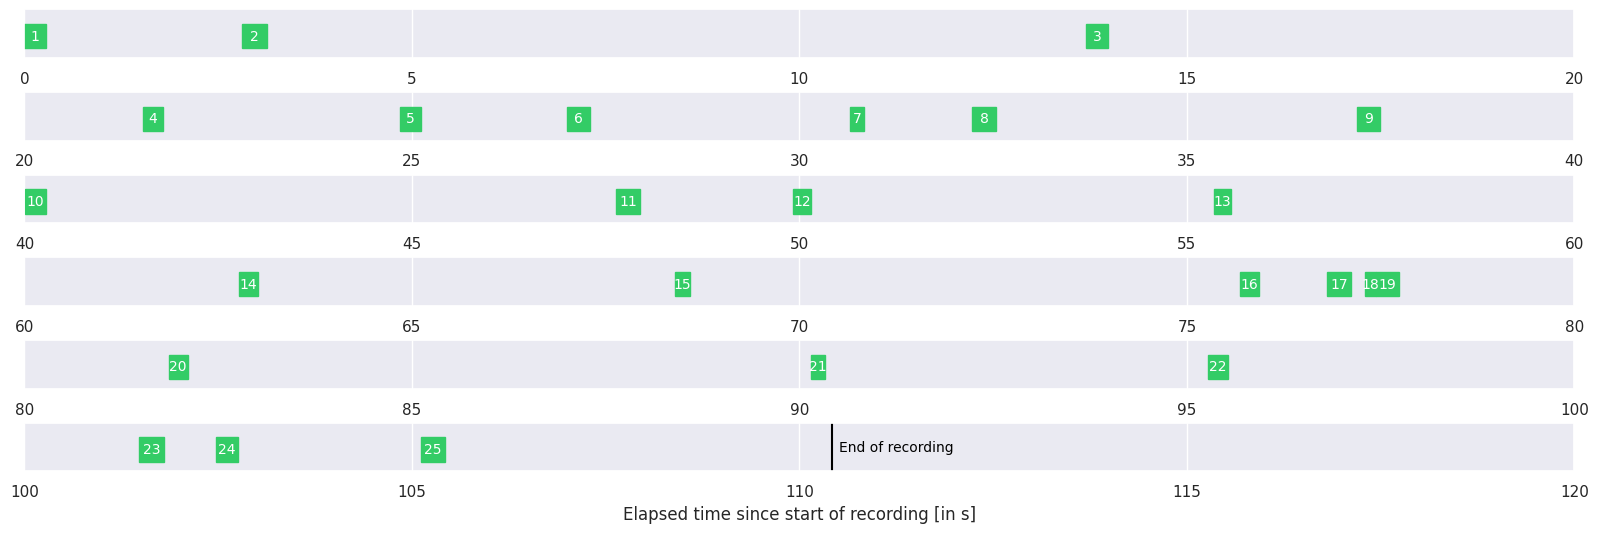

In [7]:
from blink_detector.helper import visualize_blink_events

# Limit the visualization to the first 100 s 
start_interval = 0
end_interval = 120

visualize_blink_events(blink_events, ts, start_interval, end_interval)

Great, you have finished the first part of this tutorial! Next, we'll delve into using Pupil Lab's Realtime Python API to carry out blink detection in realtime.

# <font size=5> **Part 2:** Blink detection in real time using Pupil Lab's Realtime Python API</font>

In this section we will walk you through detecting eye blinks in near-realtime using <A HREF="https://pupil-labs-realtime-api.readthedocs.io/en/stable/"><b>Pupil Lab's Real Time API</b></A>. 

Note that the temporal resolution of the blink detection is inherently limited by some of the (post-)processing parameters outlined in the [white paper](https://docs.google.com/document/d/1JLBhC7fmBr6BR59IT3cWgYyqiaM8HLpFxv5KImrN-qE/export?format=pdf). Moreover, the demands of the image processing can further impede performance. Consequently, there will be an inherent delay in blink detection, which makes it *near*-realtime rather than truly realtime.

After you have successfully set up your environment, let’s first import all the required modules:

In [1]:
import time
from collections import deque
import nest_asyncio
import numpy as np
from pupil_labs.realtime_api.simple import discover_one_device, discover_devices
from blink_detector.blink_detector import blink_detection_pipeline
from blink_detector.helper import (
    stream_images_and_timestamps,
    update_array,
    compute_blink_rate,
    plot_blink_rate,
)

Next, we need to setup the real time API. We use Python's *asyncio* to implement asynchronous communication. In some environments, for example when working with Jupyter notebooks, asyncio won't work out of the box. We will make use of *nest_asyncio*, which allows *asyncio* to work also within Jupyter notebooks. 

In [2]:
nest_asyncio.apply()

In [3]:
device = discover_one_device()
# if you have more than one device
# devices = discover_devices(10)

Printing the device name and its IP helps to make sure that the discovered device is indeed <br>
the device you would like to connect with.

In [4]:
print(f"Phone IP address: {device.phone_ip}")
print(f"Phone name: {device.phone_name}")

Phone IP address: 192.168.20.88
Phone name: Tom1


<font size=5>**2.1.** Real-time blink rate since start of recording and over the last 30s</font>

In this section, we will show you how to utilize the Realtime API in combination with the blink detection pipeline in order to perform realtime blink-rate estimation.
<br><br>**Limitation:** As the blink detection pipeline is a generator object, it will block execution of the code until a blink event is yielded. This means that any computation that is carried out within the for-loop will only execute once a blink occurs. This means that blink rate can only be updated once a blink is detected. In order to get a continous readout of blink rate, one possible way to achieve this is via multi-threading, where one thread executes the blink deteciton pipeline and a second thread updates the plots.

In [ ]:
# we need to re-initialize the streams as the previous ones have been exhausted
left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

# let's keep track of the last 100 blinks
blink_times = np.zeros(100)
avg_blink_rate = np.zeros(100)
blink_rate_last_30s = np.zeros(100)

blink_counter = 0
starting_time = time.time()

while True:

    blink_event = next(blink_detection_pipeline(left_images, right_images, timestamps))
    
    blink_counter += 1

    elapsed_time = blink_event.start_time / 1e9 - starting_time

    blink_times = update_array(blink_times, elapsed_time)

    avg_blink_rate = update_array(
        avg_blink_rate, compute_blink_rate(blink_counter, elapsed_time)
    )

    blink_counter_last_30s = np.sum(blink_times > max(blink_times[0] - 30, 0))

    blink_rate_last_30s = update_array(
        blink_rate_last_30s, blink_counter_last_30s / min(30, blink_times[0])
    )

    plot_blink_rate(blink_times, avg_blink_rate, blink_rate_last_30s)

<font size=5>**2.2.** Toggle recordings remotely through eye blinks</font>

In this section, we will write a routine that detects a rapid sequence of three eye blinks. Upon detection of said sequence, the companion device will initiate a new recording or stop an ongoing one. 

If the default temporal interval (1.0 seconds) in which the three blinks must occur is too short (or too long) for your purpose, feel free to adjust the `time_inverval` parameter. Considering that the device requires a brief moment to initiate a recording, it’s essential to ensure a minimum time lapse between the initiation and the subsequent termination of a recording. Hence, we’ll enforce a waiting period of 0.5 seconds to avoid any potential conflicts between consecutive commands.

In this example, the recording will be canceled (discarded). If you want to stop and then upload the recording to Pupil Cloud, you can `device.recording_cancel()` with `device.recording_stop_and_save()`.


In [ ]:
left_images, right_images, timestamps = stream_images_and_timestamps(
    device, is_neon=True
)

# initialize a deque with N zeros (N: number of successive blinks)
blink_queue = deque(maxlen=3)
blink_queue.extend(np.zeros(3))

# time interval within which the N blinks must occur
time_interval = 1.0

blink_event_stream = blink_detection_pipeline(left_images, right_images, timestamps)

device_is_recording = False

while True:
    
    blink_event = next(blink_event_stream)
    blink_queue.append(blink_event.start_time / 1e9)
    
    toggle_recording = blink_queue[-1] - blink_queue[0] < time_interval

    if toggle_recording:
        if device_is_recording:
            if time.time() - start_of_recording < 0.5:
                print("Time between start and stop of recording is too short.")
                time.sleep(0.5)
            print("Stop recording")
            device.recording_cancel()
            device_is_recording = False
        else:
            print("Start recording")
            device.recording_start()
            device_is_recording = True
            start_of_recording = time.time()
            
        toggle_recording = False